In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import torch
import re
import nltk
import seaborn as sns
import numpy as np
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
from sklearn.model_selection import ParameterGrid
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, Trainer, TrainingArguments

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('sentiwordnet')


c:\MySoftware\Anaconda\envs\FYP\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\MySoftware\Anaconda\envs\FYP\lib\site-packages\huggingface_hub\utils\_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(
[nltk_data] Downloading package wordnet to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to C:\Users\ASUS TUF
[nltk_data]     X506H\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords i

True

LOADING DATASET

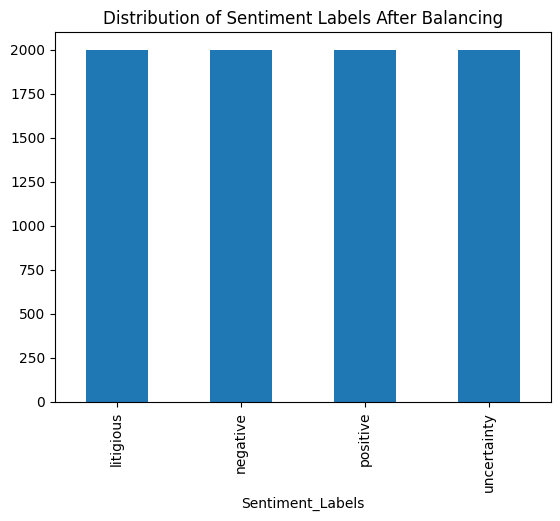

In [3]:
# Load the dataset
UnC_Data = pd.read_csv('./Sentiment_Dataset/Text/4/dataset.csv', low_memory=False)

# Filter only English tweets
UnC_Data = UnC_Data.query('Language == "en"')

# Convert all columns to string type
UnC_Data = UnC_Data.astype(str)

# Drop all rows with any NaN and NaT values
UnC_Data = UnC_Data.dropna()

# Only keep the text and label columns
UnC_Data = UnC_Data[['Text', 'Label']]

# Rename the "Label" column as "sentiment labels"
UnC_Data = UnC_Data.rename(columns={'Label': 'Sentiment_Labels'})

# Balancing the dataset
balanced_data = pd.DataFrame()

# Sample 2000 records for each label
for label in UnC_Data['Sentiment_Labels'].unique():
    label_data = UnC_Data[UnC_Data['Sentiment_Labels'] == label].sample(2000, replace=True)
    balanced_data = pd.concat([balanced_data, label_data])

# Visualize the distribution of the labels after balancing - Bar Chart
balanced_data.groupby(['Sentiment_Labels']).size().plot.bar()
plt.title('Distribution of Sentiment Labels After Balancing')
plt.show()


DATA PREPROCESSING

In [4]:
# Pre-compiling regular expressions
emoji_pattern = re.compile("["
                          u"\U0001F600-\U0001F64F"
                          u"\U0001F300-\U0001F5FF"
                          u"\U0001F680-\U0001F6FF"
                          u"\U0001F1E0-\U0001F1FF"
                          u"\U00002702-\U000027B0"
                          u"\U000024C2-\U0001F251"
                          "]+", flags=re.UNICODE)

stop_words = set(stopwords.words('english'))
lemmatizer = nltk.WordNetLemmatizer()

def clean_and_preprocess(tweet):
    if not isinstance(tweet, str):
        return ""

    # Combine regular expressions
    temp = re.sub(r'http\S+|@\S+|#|\[.*?\]|[()!?]', ' ', tweet.lower())
    temp = re.sub("[^a-z0-9\s]", " ", temp)

    # Tokenization and Lemmatization (NLTK library) using list comprehension
    words = [lemmatizer.lemmatize(word) for word in re.findall(r'\b\w+\b', temp) if word not in stop_words]

    # Join the list of words back into a sentence
    processed_sentence = " ".join(words)

    return processed_sentence

# Apply the clean_and_preprocess function to the "Text" column
C_Data = balanced_data.copy()
C_Data['Text'] = C_Data['Text'].apply(clean_and_preprocess)

In [5]:
C_Data.head(5)

,Text,Sentiment_Labels
463314,kraken shiprekt long position 70 9921 bch wort...,litigious
245883,um witness tampering,litigious
915687,thats mother daughter law,litigious
872470,yup discussion outcome different light 20th ce...,litigious
748859,love optimistic need rule law exerted right ga...,litigious


In [6]:
# Map the labels to numerical values
label_mapping = {'positive': 0, 'negative': 1, 'uncertainty': 2, 'litigious': 3}

# Add a new column "Numerical_Labels" to the dataset
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping)

# Alternatively, if you want to keep both columns, you can use the following:
C_Data['Numerical_Labels'] = C_Data['Sentiment_Labels'].map(label_mapping).astype('int')

# Set the maximum column width to a larger value
pd.set_option('display.max_colwidth', 1000)
C_Data.head(5)

,Text,Sentiment_Labels,Numerical_Labels
463314,kraken shiprekt long position 70 9921 bch worth 7 500 0 perpetual bchusd future contract 102 9 loss trade 1 8942 bch 194 91 71 2 maintenance margin 1 4507 bch retained trader 2022 06 28 22 33 25 utc,litigious,3
245883,um witness tampering,litigious,3
915687,thats mother daughter law,litigious,3
872470,yup discussion outcome different light 20th century research settlement logistics,litigious,3
748859,love optimistic need rule law exerted right garland want get biden harris schumer getting senator line pelosi starting impeachment proceeding scotus perjurors,litigious,3


In [7]:
# Adding the labels to a list to map ID to label and label to ID
labels = C_Data['Sentiment_Labels'].unique().tolist()
labels = [s.strip() for s in labels ]

label_count = len(labels)

id2label = {id: label for id, label in enumerate(labels)}
label2id = {label: id for id, label in enumerate(labels)}

# Print the ID to label and label to ID mappings
print(id2label)
print(label2id)

{0: 'litigious', 1: 'positive', 2: 'negative', 3: 'uncertainty'}
{'litigious': 0, 'positive': 1, 'negative': 2, 'uncertainty': 3}


DATA SPLITTING

In [8]:
# Split the dataset into train, test, and validation sets (8:1:1)
train_data, test_data = train_test_split(C_Data, test_size=0.2, random_state=42)
test_data, val_data = train_test_split(test_data, test_size=0.5, random_state=42)

# Save the train, test, and validation datasets to CSV files
train_data.to_csv("train_data.csv", index=False)
test_data.to_csv("test_data.csv", index=False)
val_data.to_csv("val_data.csv", index=False)

# Splitting the train, test, and validation datasets into text and label columns
SIZE= C_Data.shape[0]

train_texts = list(train_data['Text'])
val_texts = list(val_data['Text'])
test_texts = list(test_data['Text'])

# Extracting label columns
train_labels = list(train_data['Numerical_Labels'])
val_labels = list(val_data['Numerical_Labels'])
test_labels = list(test_data['Numerical_Labels'])

# Check the count of each dataset
print("Train data count:", train_data.shape[0])
print("Test data count:", test_data.shape[0])
print("Validation data count:", val_data.shape[0])

Train data count: 6400
Test data count: 800
Validation data count: 800


In [9]:
# Visualize a few samples from test_texts and corresponding test_labels
print("\nSample Test Data:")
for text, label in zip(test_texts[:5], test_labels[:5]):
    print(f"Text: {text}\nLabel: {label}\n")

# Check the count of unique labels in the test set
unique_labels_test = set(test_labels)
print("Unique Labels in Test Data:", unique_labels_test)


Sample Test Data:
Text: cisa hacker still using log4shell breach network patch system
Label: 3

Text: nanight lufflies sweet dream xx
Label: 0

Text: hopefully getting legal doc sorted soon adopt
Label: 3

Text: take risk lose chance
Label: 2

Text: answer question typical bronsexual rest case
Label: 1

Unique Labels in Test Data: {0, 1, 2, 3}


In [10]:
# Setting DistilBERT tokenizer as 'tokenizer'
tokenizer = DistilBertTokenizer.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", max_length=128)

# Set model to DistilBERTForSequenceClassification
model = DistilBertForSequenceClassification.from_pretrained("distilbert-base-uncased-finetuned-sst-2-english", 
                                                            max_length=128, 
                                                            num_labels=label_count, 
                                                            id2label=id2label, 
                                                            label2id=label2id, 
                                                            ignore_mismatched_sizes=True)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([2]) in the checkpoint and torch.Size([4]) in the model instantiated
- classifier.weight: found shape torch.Size([2, 768]) in the checkpoint and torch.Size([4, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [11]:
max_length = 128

train_encodings = tokenizer(train_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
val_encodings = tokenizer(val_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')
test_encodings = tokenizer(test_texts, truncation=True, padding=True, max_length=max_length, return_tensors='pt')


In [ ]:
class DataLoader(torch.utils.data.Dataset):

    def __init__(self, encodings, labels):

        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):

        # Retrieve tokenized data for the given index
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        # Add the label for the given index to the item dictionary
        item['labels'] = torch.tensor(self.labels[idx])
        return item

    def __len__(self):

        return len(self.labels)
    
train_dataloader = DataLoader(train_encodings, train_labels)
val_dataloader = DataLoader(val_encodings, val_labels)
test_dataset = DataLoader(test_encodings, test_labels)

# Define the hyperparameter grid for tuning
hyperparameter_grid = {
    'learning_rate': [2e-5, 1e-5],
    'num_train_epochs': [3, 4],
    'per_device_train_batch_size': [16, 32]
}

# Define the search space using ParameterGrid
param_grid = list(ParameterGrid(hyperparameter_grid))


# Define training arguments and other configurations
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",
    eval_steps=500,  
    save_steps=500,  
    logging_steps=240,  
)

# Hyperparameter tuning loop
for params in param_grid:
    print(f"Training with hyperparameters: {params}")

    # Update training arguments with hyperparameters
    training_args.learning_rate = params['learning_rate']
    training_args.num_train_epochs = params['num_train_epochs']
    training_args.per_device_train_batch_size = params['per_device_train_batch_size']

    # Create a Trainer instance with the updated TrainingArguments
    trainer = Trainer(
        model=model,
        args=training_args,
        tokenizer=tokenizer,
        train_dataset=train_dataloader,
        eval_dataset=val_dataloader
    )

    # Train the model
    trainer.train()

    # Evaluate the model on the validation set or using cross-validation
    results = trainer.evaluate()

    # Log or store the results for later analysis
    print(f"Results: {results}")



In [12]:
model_path = 'initial_base_model_v2'
#trainer.save_model(model_path)
#tokenizer.save_pretrained(model_path)

In [13]:
# Load test dataset (skip the header)
with open("val_data.csv", "r") as f:
    # Skip the header if present
    next(f)
    
    # Read the rest of the lines
    texts = [line.strip() for line in f]

# Load corresponding labels
labels = [label for label in labels]  # Update this line based on how you load labels

# Instantiate tokenizer and DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()  # Put the model in evaluation mode

# Preprocess the data
tokenized_inputs = tokenizer(texts, return_tensors="pt", padding=True)

# Generate predictions
with torch.no_grad():  # Avoid computing gradients during inference
    outputs = model(**tokenized_inputs)
predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Calculate metrics
accuracy = accuracy_score(val_labels, predictions)
precision = precision_score(val_labels, predictions, average="weighted")
recall = recall_score(val_labels, predictions, average="weighted")
f1 = f1_score(val_labels, predictions, average="weighted")

# Free up memory by deleting variables that are no longer needed
del tokenized_inputs, outputs

# Print results
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)


Accuracy: 0.95125
Precision: 0.9532558312154507
Recall: 0.95125
F1-score: 0.9515594504547354


In [16]:
# Define the label-to-id mapping used during training
label2id = {'Positive': 0, 'Negative': 1, 'Uncertainty': 2, 'Litigious': 3}

# Create a reverse mapping (id-to-label) for converting numerical labels to string labels
id_to_label = {v: k for k, v in label2id.items()}

# Input sentence
input_sentence = "im so excited to be here!"

# Tokenize the input
tokenized_input = tokenizer(input_sentence, return_tensors="pt")

# Generate predictions
with torch.no_grad():  # Avoid computing gradients during inference
    outputs = model(**tokenized_input)
#predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Obtain predicted probabilities
predicted_probabilities = torch.nn.functional.softmax(outputs.logits, dim=1)

# Get the predicted class (numerical label)
predicted_class = torch.argmax(predicted_probabilities, dim=1).item()

# Convert numerical label to string label using the reverse mapping
predicted_sentiment = id_to_label.get(predicted_class, "Unknown")

# Print results
print("Predicted Sentiment Class:", predicted_sentiment)
print("Predicted Probabilities:", predicted_probabilities.tolist())


Predicted Sentiment Class: Positive
Predicted Probabilities: [[1.0, 4.3650295822317275e-08, 8.66688054657061e-09, 2.682565725109498e-09]]


In [14]:
# Convert the lists to numpy arrays
test_labels = np.array(test_labels)
val_labels = np.array(val_labels)
predictions = np.array(predictions)

# Print the shape of test_labels and predictions
print("Shape of test_labels:", test_labels.shape)
print("Shape of val_labels:", val_labels.shape)
print("Shape of predictions:", predictions.shape)


Shape of test_labels: (800,)
Shape of val_labels: (800,)
Shape of predictions: (800,)


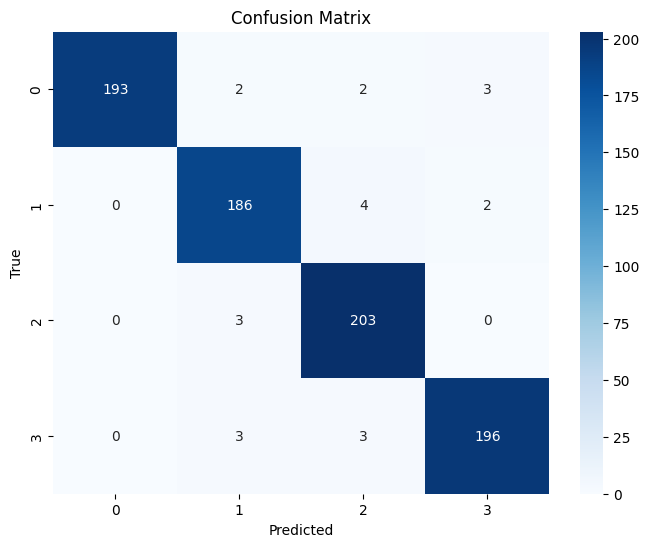

Classification Report:
              precision    recall  f1-score   support

     Class 0       1.00      0.96      0.98       200
     Class 1       0.96      0.97      0.96       192
     Class 2       0.96      0.99      0.97       206
     Class 3       0.98      0.97      0.97       202

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [17]:
# Load test dataset (skip the header)
with open("test_data.csv", "r") as f:
    # Skip the header if present
    next(f)
    
    # Read the rest of the lines
    texts = [line.strip() for line in f]

# Instantiate tokenizer and DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Preprocess the data
tokenized_inputs = tokenizer(texts, return_tensors="pt", padding=True)

# Generate predictions
with torch.no_grad():  
    outputs = model(**tokenized_inputs)
predictions = torch.argmax(outputs.logits, dim=1).tolist()

# Compute confusion matrix
conf_matrix = confusion_matrix(test_labels, predictions)

# Visualize confusion matrix using seaborn
classes = [f'Class {i}' for i in range(len(set(test_labels)))]
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='g', cmap='Blues', xticklabels=set(test_labels), yticklabels=set(test_labels))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report for additional metrics
print("Classification Report:")
print(classification_report(test_labels, predictions, target_names=classes))


In [15]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np

# Load test dataset (skip the header)
with open("test_data.csv", "r") as f:
    # Skip the header if present
    next(f)
    
    # Read the rest of the lines
    texts = [line.strip() for line in f]

# Instantiate tokenizer and DistilBERT model
tokenizer = DistilBertTokenizer.from_pretrained(model_path)
model = DistilBertForSequenceClassification.from_pretrained(model_path)
model.eval()

# Preprocess the data
tokenized_inputs = tokenizer(texts, return_tensors="pt", padding=True)

# Generate predictions
with torch.no_grad():  
    outputs = model(**tokenized_inputs)
predictions = torch.argmax(outputs.logits, dim=1).tolist()


# Calculate metrics
accuracy = accuracy_score(test_labels, predictions)
precision_macro = precision_score(test_labels, predictions, average='macro')
recall_macro = recall_score(test_labels, predictions, average='macro')
f1_macro = f1_score(test_labels, predictions, average='macro')

precision_micro = precision_score(test_labels, predictions, average='micro')
recall_micro = recall_score(test_labels, predictions, average='micro')
f1_micro = f1_score(test_labels, predictions, average='micro')

# Print or store the metrics
print(f"Accuracy: {accuracy}")
print(f"Macro Precision: {precision_macro}, Recall: {recall_macro}, F1: {f1_macro}")
print(f"Micro Precision: {precision_micro}, Recall: {recall_micro}, F1: {f1_micro}")

# Print detailed classification report
print(classification_report(test_labels, predictions))


Accuracy: 0.9725
Macro Precision: 0.9728586086296779, Recall: 0.9723709807267134, F1: 0.9724788614456219
Micro Precision: 0.9725, Recall: 0.9725, F1: 0.9725
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       200
           1       0.96      0.97      0.96       192
           2       0.96      0.99      0.97       206
           3       0.98      0.97      0.97       202

    accuracy                           0.97       800
   macro avg       0.97      0.97      0.97       800
weighted avg       0.97      0.97      0.97       800



In [16]:
from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
import numpy as np

# Calculate micro and macro-averaged F1 score
micro_f1 = f1_score(test_labels, predictions, average='micro')
macro_f1 = f1_score(test_labels, predictions, average='macro')

# Calculate accuracy for reference
accuracy = accuracy_score(test_labels, predictions)

# Print or use the metrics
print(f"Micro F1 Score: {micro_f1}")
print(f"Macro F1 Score: {macro_f1}")
print(f"Accuracy: {accuracy}")


Micro F1 Score: 0.9725
Macro F1 Score: 0.9724788614456219
Accuracy: 0.9725
